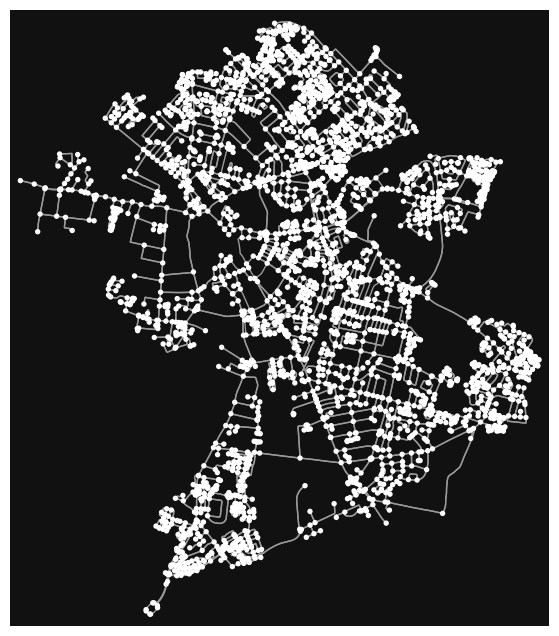

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [8]:
import osmnx as ox
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import re




# Download a street network for a small area
G = ox.graph_from_place("Cambridge, UK", network_type="drive")

# Simplify and clean the network
G = G.subgraph(max(nx.strongly_connected_components(G), key=len)).copy()

# Plot it
ox.plot_graph(G)

In [4]:
'''

# Download drivable street network for a small area
G = ox.graph_from_place("Cambridge, UK", network_type="drive")
G = G.subgraph(max(nx.strongly_connected_components(G), key=len)).copy()

# Convert to nodes and edges DataFrames
nodes, edges = ox.graph_to_gdfs(G)

# Export to CSV
nodes[['x', 'y']].to_csv("nodes.csv")
edges[['u', 'v']].to_csv("edges.csv")
'''

'\n\n# Download drivable street network for a small area\nG = ox.graph_from_place("Cambridge, UK", network_type="drive")\nG = G.subgraph(max(nx.strongly_connected_components(G), key=len)).copy()\n\n# Convert to nodes and edges DataFrames\nnodes, edges = ox.graph_to_gdfs(G)\n\n# Export to CSV\nnodes[[\'x\', \'y\']].to_csv("nodes.csv")\nedges[[\'u\', \'v\']].to_csv("edges.csv")\n'

In [5]:
# Convert to nodes and edges DataFrames
nodes, edges = ox.graph_to_gdfs(G)

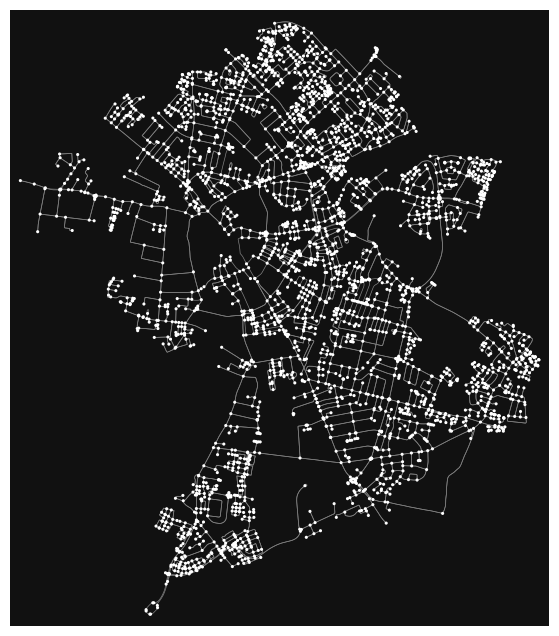

In [6]:
# Load graph (from previous step)
G = ox.graph_from_place("Cambridge, UK", network_type="drive")
G = G.subgraph(max(nx.strongly_connected_components(G), key=len)).copy()

# Plot the network
fig, ax = ox.plot_graph(G, node_size=5, edge_color='gray', edge_linewidth=0.5)

In [11]:
def parse_speed(value):
    if isinstance(value, list):
        value = value[0]
    if isinstance(value, str):
        match = re.search(r'(\d+)', value)
        if match:
            return float(match.group(1))
    elif isinstance(value, (int, float)):
        return float(value)
    return 50.0  # default fallback

In [12]:
for u, v, k, data in G.edges(keys=True, data=True):
    length_km = data.get("length", 0) / 1000  # meters to km
    speed_kph = parse_speed(data.get("maxspeed", 50))
    data["travel_time"] = length_km / (speed_kph / 60)  # time in minutes

In [13]:
import random

nodes = list(G.nodes())
num_agents = 5
agents = []

for _ in range(num_agents):
    origin, destination = random.sample(nodes, 2)
    try:
        path = nx.shortest_path(G, origin, destination, weight='travel_time')
        agents.append({
            'path': path,
            'position_index': 0,
            'finished': False,
            'travel_time': 0
        })
    except nx.NetworkXNoPath:
        continue

In [15]:
for step in range(100):  # max 100 time steps
    for agent in agents:
        if agent['finished']:
            continue
        
        path = agent['path']
        idx = agent['position_index']
        
        if idx < len(path) - 1:
            # get current and next nodes
            u = path[idx]
            v = path[idx + 1]
            edge_data = G.get_edge_data(u, v, default={})
            time_cost = edge_data.get('travel_time', 1.0)
            
            # move to next node
            agent['position_index'] += 1
            agent['travel_time'] += time_cost
        else:
            agent['finished'] = True

In [ ]:
occupied_nodes = set()

for step in range(100):
    occupied_nodes.clear()
    
    for agent in agents:
        if agent['finished']:
            continue
        
        path = agent['path']
        idx = agent['position_index']
        
        if idx < len(path) - 1:
            next_node = path[idx + 1]
            
            if next_node not in occupied_nodes:
                u = path[idx]
                v = next_node
                edge_data = G.get_edge_data(u, v, default={})
                time_cost = edge_data.get('travel_time', 1.0)

                agent['position_index'] += 1
                agent['travel_time'] += time_cost
                occupied_nodes.add(next_node)
            else:
                # can't move, wait at current node
                agent['travel_time'] += 1.0
        else:
            agent['finished'] = True

In [17]:
for i, agent in enumerate(agents):
    print(f"Agent {i}: Travel time = {agent['travel_time']:.2f} min, Path length = {len(agent['path'])}")


Agent 0: Travel time = 43.00 min, Path length = 44
Agent 1: Travel time = 38.00 min, Path length = 39
Agent 2: Travel time = 12.00 min, Path length = 13
Agent 3: Travel time = 71.00 min, Path length = 72
Agent 4: Travel time = 64.00 min, Path length = 65


In [18]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the road network once
positions = {n: (d['x'], d['y']) for n, d in G.nodes(data=True)}
for u, v in G.edges():
    if u in positions and v in positions:
        x1, y1 = positions[u]
        x2, y2 = positions[v]
        ax.plot([x1, x2], [y1, y2], color='lightgray', linewidth=0.5)

# Initialize agent dots
agent_plots = [ax.plot([], [], 'ro')[0] for _ in agents]

# Congestion tracker
occupied_nodes = set()

def init():
    for p in agent_plots:
        p.set_data([], [])
    return agent_plots

def update(frame):
    occupied_nodes.clear()
    for i, agent in enumerate(agents):
        if agent['finished']:
            continue
        path = agent['path']
        idx = agent['position_index']
        if idx < len(path) - 1:
            next_node = path[idx + 1]
            if next_node not in occupied_nodes:
                u = path[idx]
                v = next_node
                edge_data = G.get_edge_data(u, v, default={})
                time_cost = edge_data.get('travel_time', 1.0)

                agent['position_index'] += 1
                agent['travel_time'] += time_cost
                occupied_nodes.add(next_node)

                # Plot new position
                x, y = positions[next_node]
                agent_plots[i].set_data(x, y)
            else:
                # Wait at current node
                current_node = path[idx]
                agent['travel_time'] += 1.0
                x, y = positions[current_node]
                agent_plots[i].set_data(x, y)
        else:
            agent['finished'] = True
    return agent_plots

ani = animation.FuncAnimation(fig, update, frames=60, init_func=init, blit=True, interval=300, repeat=False)
plt.close()
ani


In [19]:
from matplotlib.animation import PillowWriter
ani.save("traffic_sim.gif", writer=PillowWriter(fps=2))